In [ ]:
daf8016fa1ae4d55ab478bf8432bd3e3

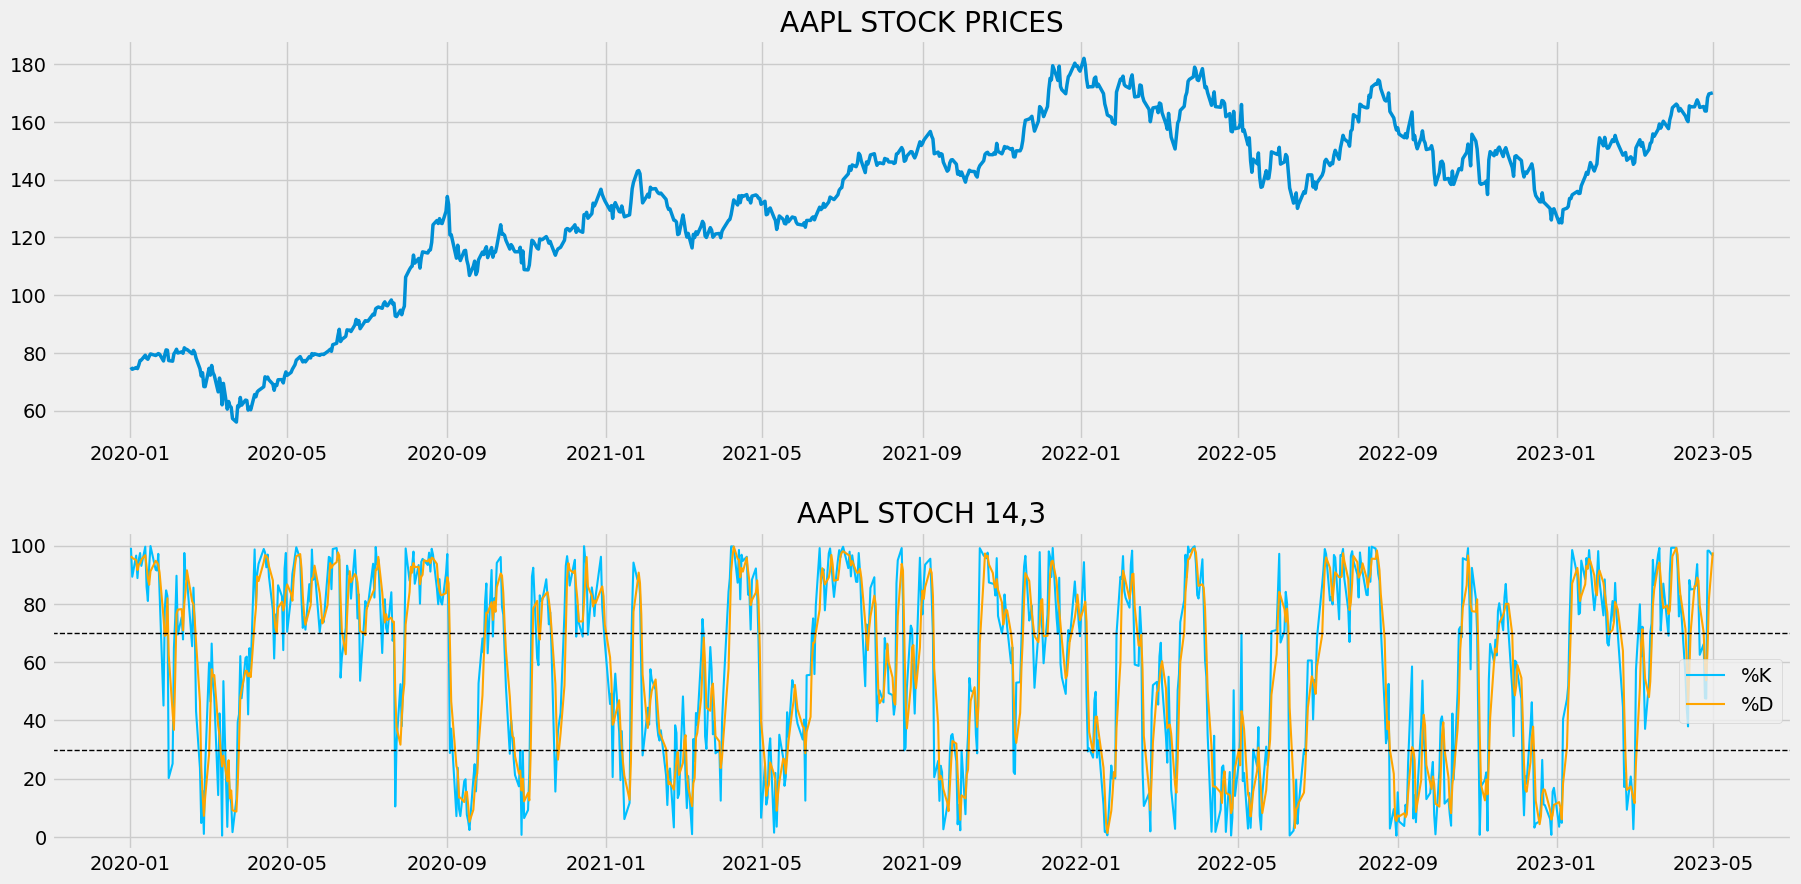

Profit gained from the STOCH MACD strategy by investing $100k in AAPL : 1491122.1
Profit percentage of the STOCH MACD strategy : 1491%
Benchmark profit by investing $100k : 267660.53
Benchmark Profit percentage : 267%
STOCH MACD Strategy profit is 1224% higher than the Benchmark Profit


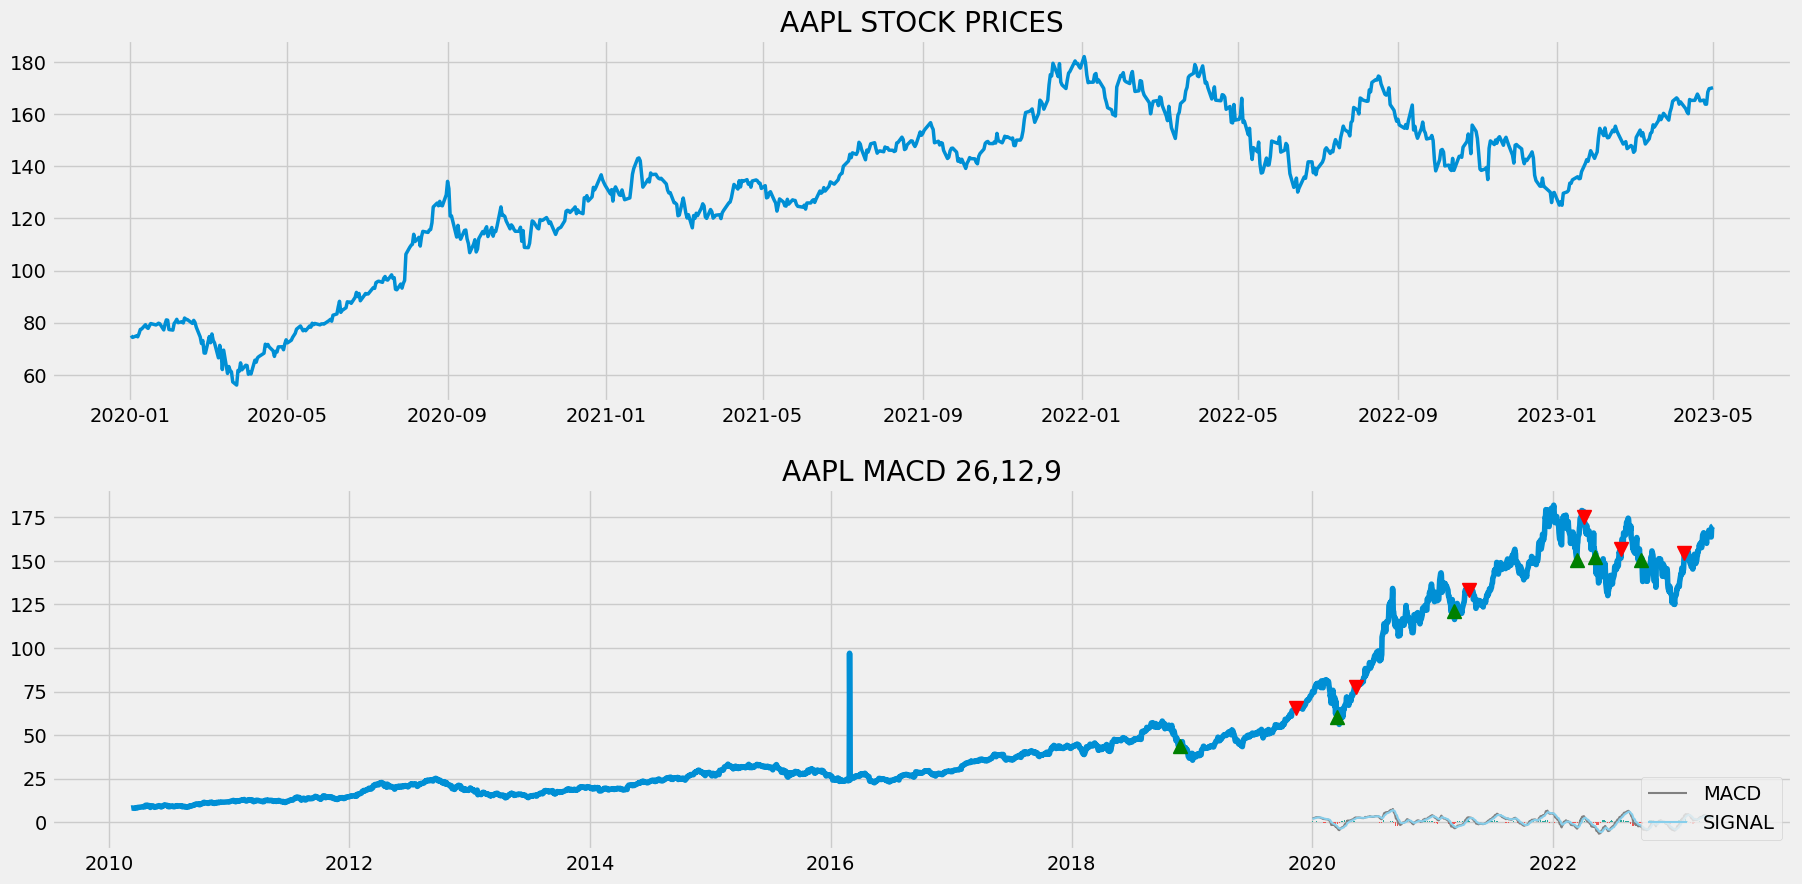

In [8]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

# EXTRACTING STOCK DATA

def get_historical_data(symbol, start_date):
    api_key = 'daf8016fa1ae4d55ab478bf8432bd3e3'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
#     raw_df = requests.get(api_url).json()
#     print(raw_df)
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df

# aapl = get_historical_data('AAPL', '2010-01-01')
aapl.tail()

# STOCHASTIC OSCILLATOR CALCULATION

def get_stoch_osc(high, low, close, k_lookback, d_lookback):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

aapl['%k'], aapl['%d'] = get_stoch_osc(aapl['high'], aapl['low'], aapl['close'], 14, 3)
aapl.tail()

# STOCHASTIC OSCILLATOR PLOT

plot_data = aapl[aapl.index >= '2020-01-01']

ax1 = plt.subplot2grid((14,1), (0,0), rowspan = 7, colspan = 1)
ax2 = plt.subplot2grid((15,1), (9,0), rowspan = 6, colspan = 1)
ax1.plot(plot_data['close'], linewidth = 2.5)
ax1.set_title('AAPL STOCK PRICES')
ax2.plot(plot_data['%k'], color = 'deepskyblue', linewidth = 1.5, label = '%K')
ax2.plot(plot_data['%d'], color = 'orange', linewidth = 1.5, label = '%D')
ax2.axhline(70, color = 'black', linewidth = 1, linestyle = '--')
ax2.axhline(30, color = 'black', linewidth = 1, linestyle = '--')
ax2.set_title(f'AAPL STOCH 14,3')
ax2.legend(loc = 'right')
plt.show()

# MACD CALCULATION

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    return macd, signal, hist

aapl['macd'] = get_macd(aapl['close'], 26, 12, 9)[0]
aapl['macd_signal'] = get_macd(aapl['close'], 26, 12, 9)[1]
aapl['macd_hist'] = get_macd(aapl['close'], 26, 12, 9)[2]
aapl = aapl.dropna()
aapl.tail()

# MACD PLOT

plot_data = aapl[aapl.index >= '2020-01-01']

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)

    ax1.plot(prices, linewidth = 2.5)
    ax1.set_title('AAPL STOCK PRICES')
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax2.set_title('AAPL MACD 26,12,9')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(plot_data['close'], plot_data['macd'], plot_data['macd_signal'], plot_data['macd_hist'])

# TRADING STRATEGY

def implement_stoch_macd_strategy(prices, k, d, macd, macd_signal):    
    buy_price = []
    sell_price = []
    stoch_macd_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 30 and d[i] < 30 and macd[i] < -2 and macd_signal[i] < -2:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
                
        elif k[i] > 70 and d[i] > 70 and macd[i] > 2 and macd_signal[i] > 2:
            if signal != -1 and signal != 0:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
        
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_macd_signal.append(0)
            
    return buy_price, sell_price, stoch_macd_signal
            
buy_price, sell_price, stoch_macd_signal = implement_stoch_macd_strategy(aapl['close'], aapl['%k'], aapl['%d'], aapl['macd'], aapl['macd_signal'])

# TRADING SIGNALS PLOT

plt.plot(aapl['close'])
plt.plot(aapl.index, buy_price, marker = '^', markersize = 10, color = 'green')
plt.plot(aapl.index, sell_price, marker = 'v', markersize = 10, color = 'r')

# POSITION

position = []
for i in range(len(stoch_macd_signal)):
    if stoch_macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(aapl['close'])):
    if stoch_macd_signal[i] == 1:
        position[i] = 1
    elif stoch_macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = aapl['close']
k_line = aapl['%k']
d_line = aapl['%d']
macd_line = aapl['macd']
signal_line = aapl['macd_signal']
stoch_macd_signal = pd.DataFrame(stoch_macd_signal).rename(columns = {0:'stoch_macd_signal'}).set_index(aapl.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_macd_position'}).set_index(aapl.index)

frames = [close_price, k_line, d_line, macd_line, signal_line, stoch_macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()
strategy[-75:-70]

# BACKTESTING

aapl_ret = pd.DataFrame(np.diff(aapl['close'])).rename(columns = {0:'returns'})
stoch_macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i] * strategy['stoch_macd_position'][i]
        stoch_macd_strategy_ret.append(returns)
    except:
        pass
    
stoch_macd_strategy_ret_df = pd.DataFrame(stoch_macd_strategy_ret).rename(columns = {0:'stoch_macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value / aapl['close'][0])
stoch_macd_investment_ret = []

for i in range(len(stoch_macd_strategy_ret_df['stoch_macd_returns'])):
    returns = number_of_stocks * stoch_macd_strategy_ret_df['stoch_macd_returns'][i]
    stoch_macd_investment_ret.append(returns)

stoch_macd_investment_ret_df = pd.DataFrame(stoch_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(stoch_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)
print(cl('Profit gained from the STOCH MACD strategy by investing $100k in AAPL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the STOCH MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

# SPY ETF COMPARISON

def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

# benchmark = get_benchmark('2010-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)

benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('STOCH MACD Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

In [9]:
# import pandas as pd
# from sklearn import linear_model
# import statsmodels.api as sm

# data = {'year': [2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016],
#         'month': [12,11,10,9,8,7,6,5,4,3,2,1,12,11,10,9,8,7,6,5,4,3,2,1],
#         'interest_rate': [2.75,2.5,2.5,2.5,2.5,2.5,2.5,2.25,2.25,2.25,2,2,2,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75],
#         'unemployment_rate': [5.3,5.3,5.3,5.3,5.4,5.6,5.5,5.5,5.5,5.6,5.7,5.9,6,5.9,5.8,6.1,6.2,6.1,6.1,6.1,5.9,6.2,6.2,6.1],
#         'index_price': [1464,1394,1357,1293,1256,1254,1234,1195,1159,1167,1130,1075,1047,965,943,958,971,949,884,866,876,822,704,719]        
#         }

# df = pd.DataFrame(data)

# df=fm_dam_ida1.copy()

# x = df[['IDA1', 'DAM']]
# y = df['net_volume']
 
# # with sklearn
# regr = linear_model.LinearRegression()
# regr.fit(x, y)

# print('Intercept: \n', regr.intercept_)
# print('Coefficients: \n', regr.coef_)

# # with statsmodels
# x = sm.add_constant(x) # adding a constant
 
# model = sm.OLS(y, x).fit()
# predictions = model.predict(x) 
 
# print_model = model.summary()
# print(print_model)

# import matplotlib.pyplot as plt

# # extract intercept b and slope m
# # b, m = 
# model.params

# # # plot y = m*x + b
# # plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$')


# # # corr_matrix = final_df.corr()

# # # # Plot the correlation matrix using Seaborn heatmap
# # # sns.heatmap(corr_matrix, annot=True)

# # from statsmodels.tsa.vector_ar.vecm import coint_johansen

# # ts = final_df.drop(['start_date', 'trade_date', 'start_time', 'DAM', 'IDA1', 'IDA2', 'IDA3',
# #        'BM', 'net_volume', 'year', 'start_time_cat', 'start_date_time',
# #        'best_market', 'best_market_price', ], axis=1)

# # # ts['year'] = ts['year'].astype(int)

# # ts = ts.dropna()

# # result = coint_johansen(ts, det_order=0, k_ar_diff=1)

# # # Print eigenvalues and critical values
# # print("Eigenvalues:\n", result.eig)
# # print("\nCritical values (90%, 95%, 99%):\n", result.cvt)
# # # plt.plot(ts)
# # # plt.title('Sample Time Series')
# # # plt.show()

# # # Define a function to perform the ADF test and print the results
# # def adf_test(timeseries):
# #     print('Results of Augmented Dickey-Fuller Test:')
# #     adf_result = adfuller(timeseries, autolag='AIC')
# #     adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
# #     for key,value in adf_result[4].items():
# #         adf_output['Critical Value (%s)'%key] = value
# #     print(adf_output)

# # # # Perform the ADF test on the time series
# # # adf_test(ts)
# # ts

# cols = ['DAM', 'IDA1', 'BM', 'net_volume', 'demand', 'wind', 'gb_price', 'hist_gas_price']

# # Perform Johansen test
# jres = coint_johansen(final_df[cols].values, -1, 1)

# # Print the results
# print("Eigenvalues: ", jres.eig)
# print("Trace statistic: ", jres.lr1)
# print("Maximum eigenvalue statistic: ", jres.lr2)
# print("Critical values: ", jres.cvm)

In [15]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import numpy as np
import timeseries 

for i,val in enumerate(acf(pU)):
    if val < 1/np.exp(1):
        print(i,val)
        Te = i
        val_Te = val
        break
dof = (len(pU)*1)/(2*Te)
print(f"Num degrees of freedom is {dof}")
fig = tsaplots.plot_acf(pU, lags=100,alpha=0.05)
plt.plot(Te,val_Te,'bo')
plt.axhline(val_Te,color='b',label='Te')
plt.legend(loc=0)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title(f'Autocorrelation pU, dof = {dof}',fontsize=14)
plt.savefig(f'Autocorr_pU.png',bbox_inches='tight')
plt.close('all')

NameError: name 'pU' is not defined